Loading dataset

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

# File paths
x_train_path = 'x_train.npy'
x_test_path = 'x_test.npy'
model_path = 'denoising_model.keras'

def save_mnist_dataset(x_train, x_test):
    np.save(x_train_path, x_train)
    np.save(x_test_path, x_test)

def load_mnist_dataset():
    x_train = np.load(x_train_path)
    x_test = np.load(x_test_path)
    return x_train, x_test

if os.path.exists(x_train_path) and os.path.exists(x_test_path):
    x_train, x_test = load_mnist_dataset()
    print("Loaded dataset from files.")
else:
    # Load MNIST dataset - ignoring labels as only need the img data
    (x_train, _), (x_test, _) = mnist.load_data()
    
    # Normalize
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Save (for future use)
    save_mnist_dataset(x_train, x_test)
    print("Downloaded and saved dataset to files.")

# Reshape data to include the channel dimension
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


Loaded dataset from files.


Adding noisiness to dataset

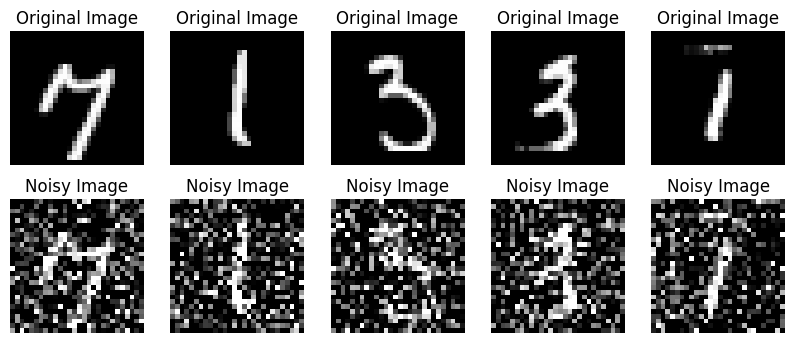

In [35]:
# Function to add AWGN noise
def add_awgn_noise(images, mean=0.0, std=0.5):
    noisy_images = images + np.random.normal(mean, std, images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

# Add noise to the training and test sets
x_train_noisy = add_awgn_noise(x_train)
x_test_noisy = add_awgn_noise(x_test)

# Display random original and noisy image
n = 5
random_indices = np.random.choice(len(x_train), n, replace=False)
plt.figure(figsize=(10, 4))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[idx].reshape(28, 28), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_noisy[idx].reshape(28, 28), cmap='gray')
    plt.title('Noisy Image')
    plt.axis('off')
plt.show()

Creating model and training it

In [36]:
if os.path.exists(model_path):
    model = load_model(model_path)
    print("Loaded model from file.")
else:
    model = Sequential()

    # Encoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Decoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

    model.compile(optimizer='adam', loss='binary_crossentropy')

    # Display the summary
    #model.summary()

    # Train
    model.fit(x_train_noisy, x_train,
                    epochs=10,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test),
                    verbose=1)

    # Save
    model.save(model_path)
    print("Trained and saved model to file.")

Loaded model from file.


Evaulating the model

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


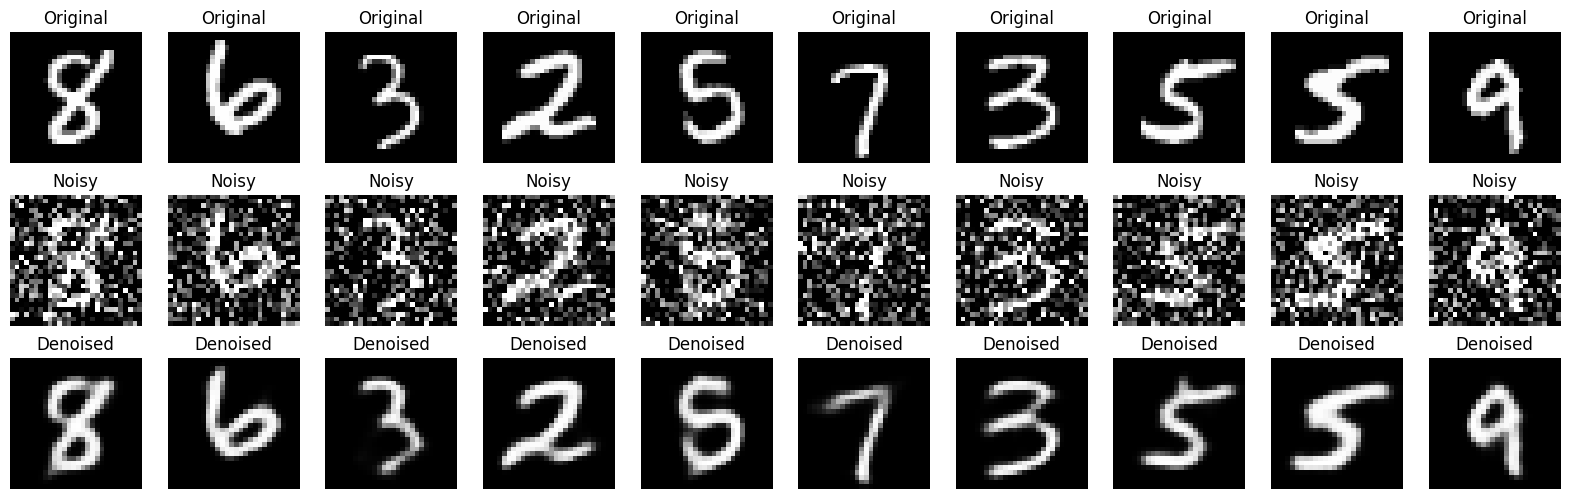

In [38]:
# Predict on the test set
x_test_denoised = model.predict(x_test_noisy)

# Display original, noisy, and denoised images
n = 10
random_indices = np.random.choice(len(x_test), n, replace=False)
plt.figure(figsize=(20, 6))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[idx].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test_denoised[idx].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')
plt.show()